In [279]:
import pandas as pd
import numpy as np
from PIL import Image

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data & Preprocessing

In [42]:
transform = tv.transforms.Compose([
    tv.transforms.Resize(56),
    tv.transforms.ToTensor(), 
    # collapse the color channels by taking the average
    tv.transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True)),
    # normalize the image
    tv.transforms.Normalize(mean=[0.5], std=[0.5]),
    # completely black or completely white
    tv.transforms.Lambda(lambda x: (x != 1).float()),
    # randomly rotate the image
    tv.transforms.RandomRotation(45),
])

dataset = tv.datasets.ImageFolder('./shapes2/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [43]:
images, labels = next(iter(dataloader))
images.shape

torch.Size([8, 1, 56, 56])

# Convolution

## Helper functions

In [44]:
def showOneGrid(grid, w, h, is_inverted=False):
    fig = plt.figure(figsize=(w, h))
    grid_imgs = tv.utils.make_grid(grid)
    if is_inverted:
        plt.imshow(1 - grid_imgs.permute(1, 2, 0))
    else:
        plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.show()
    
def showGrids(grids, w, h, r, c, is_inverted=False):
    fig = plt.figure(figsize=(w, h))
    for i in range(len(grids)):
        grid_imgs = tv.utils.make_grid(grids[i])
        fig.add_subplot(r, c, i+1)
        if is_inverted:
            plt.imshow(1 - grid_imgs.permute(1, 2, 0))
        else:
            plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.show()

def applyKernal(images, kernals):
    result = F.conv2d(images, t.tensor([kernals], dtype=t.float32).unsqueeze(0))
    result = result.clamp(min=0) / result.max()
    return result

## Applying kernals

In [45]:
edge_threshold = 0.6
corner_threshold = 0.85

kernals = [
    [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], # vertical left edge
    [[-1, -1, -1], [0, 0, 0], [1, 1, 1]], # horizontal top edge
    [[1, 0, -1], [1, 0, -1], [1, 0, -1]], # vertical right edge
    [[1, 1, 1], [0, 0, 0], [-1, -1, -1]], # horizontal bottom edge
]

edges = [applyKernal(images, kernal) for kernal in kernals]

# between main edges
for i in range(4):
    next_i = (i + 1) % 4
    edges.append((edges[i].logical_and(edges[next_i]) > corner_threshold).float())

for i in range(4):
    edges[i] = (edges[i] > edge_threshold).float()

## Displaying results

Original Images


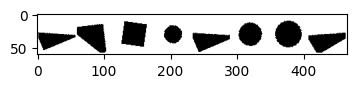

Edges


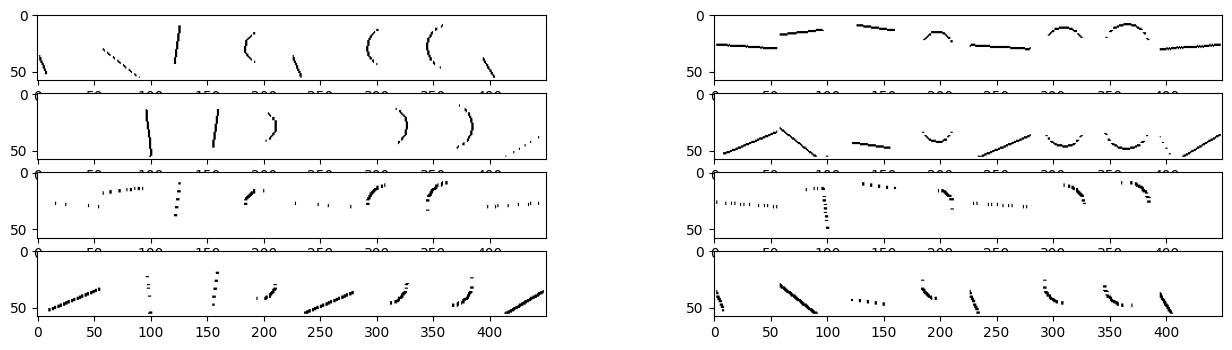

In [46]:
print("Original Images")
showOneGrid(images, 4, 2, is_inverted=True)
print("Edges")
showGrids(edges, w=16, h=8, r=8, c=2, is_inverted=True)

# Line & arc detection/clustering
## Detection testing

In [47]:
from sklearn.cluster import DBSCAN, KMeans
from scipy import sparse

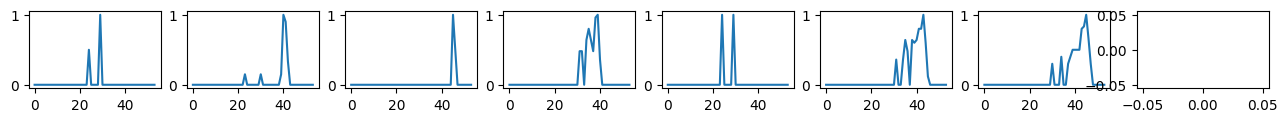

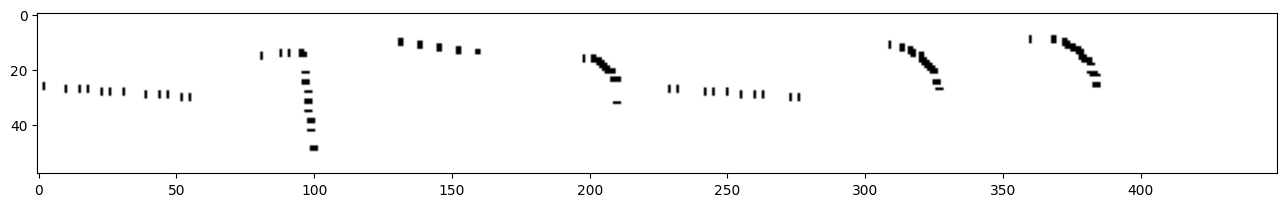

In [323]:
test_images = edges[5]

plt.figure(figsize=(16, 1))
for i in range(test_images.shape[0]):
    h_sum = test_images[i][0].sum(dim=0)
    v_sum = test_images[i][0].sum(dim=1)

    v_sum = v_sum.flip(0) # does not work for all cases. Depending on the orientation of the image. Might need to be switched to horizontal flip.

    plt.subplot(1, 8, i+1)
    shape_graph = (h_sum * v_sum)
    shape_graph /= shape_graph.max()
    plt.plot(shape_graph)

showOneGrid(test_images, 16, 3, is_inverted=True)
plt.show()

Line can be seen as a single sharp spike while arc is more wide at the base

## Clustering testing

torch.Size([100, 100])


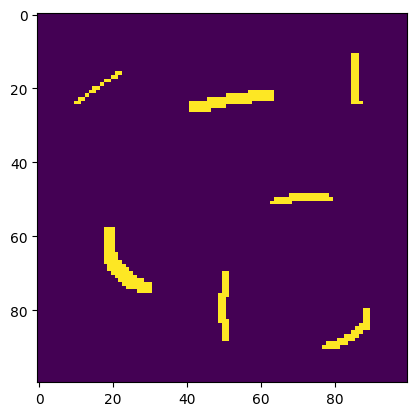

In [301]:
test_image = t.tensor(np.array(Image.open('./test_edges.png')))
test_image = test_image[..., :1]
test_image = test_image.squeeze(-1)
test_image = test_image / 255
test_image = (test_image == 0).float()
print(test_image.shape)
plt.imshow(test_image)

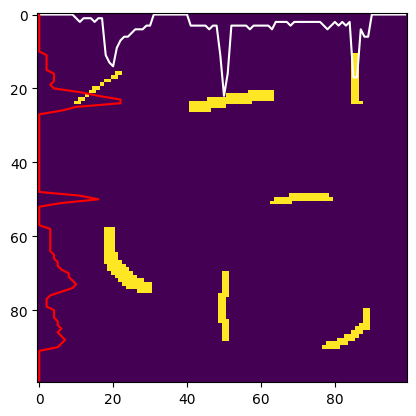

In [322]:
h_sum = test_image.sum(dim=0)
v_sum = test_image.sum(dim=1)

plt.imshow(test_image)
plt.plot(h_sum, color='white')
plt.plot(v_sum, range(len(v_sum)), color='red')
plt.show()

> 
> Test: filter line spike and arc spike into different image
> 

## DBScan

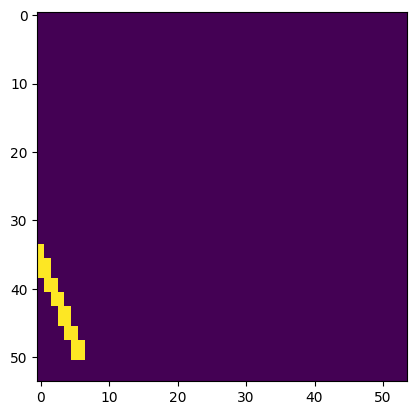

In [77]:
def dbscanCluster(data, eps=0.0001, min_samples=1):
    dbs = DBSCAN(eps=eps, min_samples=min_samples)
    X = sparse.csr_matrix(data.view(-1, 1).numpy())
    dbs.fit(X)
    Y = dbs.labels_.reshape(data.shape)

    plt.imshow(Y[0])
    plt.show()

dbscanCluster(test_images, eps=0.05, min_samples=1)